In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


In [2]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 14, 6))]]
print((mobility_df['Field of Education'].nunique())) 
mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()

141


In [3]:
mobility_df.drop('Activity (mob)',axis=1, inplace=True)
display(mobility_df)

,Sending Organization,Receiving Organization,Participants,Sending Country Code,Field of Education
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,AT,Music and performing arts
195,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,UA,Environmental protection technology
196,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,UA,Electronics and automation
197,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,UA,Mechanics and metal trades
198,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,AT,Mining and extraction
...,...,...,...,...,...
667190,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,UK,Political sciences and civics
667191,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,UK,Political sciences and civics
667192,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1,RU,Economics
667193,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1,UK,"Arts and humanities, inter-disciplinary progra..."


In [4]:
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not further defined','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', inter-disciplinary programmes','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classified','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(' not elsewhere classified','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classifed','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.lower()
mobility_df['Field of Education'] = mobility_df['Field of Education'].str.strip()

In [5]:
print(mobility_df['Field of Education'].nunique())
print(np.sort(mobility_df['Field of Education'].unique()))

106
['accounting and taxation' 'agriculture'
 'agriculture, forestry, fisheries and veterinary'
 'architecture and construction' 'architecture and town planning' 'arts'
 'arts and humanities' 'audio-visual techniques and media production'
 'biochemistry' 'biological and related sciences' 'biology'
 'building and civil engineering' 'business and administration'
 'business, administration and law'
 'care of the elderly and of disabled adults'
 'chemical engineering and processes' 'chemistry'
 'child care and youth services' 'community sanitation' 'computer use'
 'crop and livestock production'
 'database and network design and administration' 'dental studies'
 'domestic services' 'earth sciences' 'economics' 'education'
 'education science' 'electricity and energy' 'electronics and automation'
 'engineering and engineering trades'
 'engineering, manufacturing and construction' 'environment'
 'environmental protection technology' 'environmental sciences'
 'fashion, interior and industrial

In [6]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
print(ns.fraction_in_giant(adj_matrix_crs))

0.9936995471549518


In [7]:
dd = {}
for field in mobility_df['Field of Education'].unique():
    temp_df = mobility_df.loc[mobility_df['Field of Education'] == field]
    temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    dd[field] = ns.fraction_in_giant(temp_adj)
field_df = pd.DataFrame.from_dict(dd, orient='index', columns=['percentage'])
print('Top', 10, 'for', 'percentage')
pd.set_option('display.max_rows', 10)
field_df = field_df.sort_values('percentage', ascending=False)
display(field_df.head(10))

Top 10 for percentage


,percentage
business and administration,0.403032
engineering and engineering trades,0.290805
management and administration,0.285095
economics,0.281355
information and communication technologies (icts),0.252018
languages,0.235479
political sciences and civics,0.208309
literature and linguistics,0.183698
law,0.179563
arts,0.177200


TODO: Add an iterative version of it, checking if 2 or more field of education can get a percentage of nodes in the giant component close to the one with all the edges (99.36%).
You can also work in the other way around iteratively deleting edges of one field 

In [8]:
import itertools
fields = mobility_df['Field of Education'].unique()
subsets = []
for L in range(1,5):
    for subset in itertools.combinations(fields, L):
        subsets +=[subset,]
print(len(subsets))

5166281


Let's try removing fields.

In [9]:
fields = mobility_df['Field of Education'].unique()
dd = {}
for field in fields:
    temp_df = mobility_df.loc[mobility_df['Field of Education'] != field]
    temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    dd[field] = ns.fraction_in_giant(temp_adj)
field_df = pd.DataFrame.from_dict(dd, orient='index', columns=['percentage'])
field_df = field_df.sort_values('percentage')
print('Percentages removing 1 field of education:')
print('Bottom 10 for percentage')
display(field_df.head(10))

Percentages removing 1 field of education:
Bottom 10 for percentage


,percentage
music and performing arts,0.954912
business and administration,0.963576
engineering and engineering trades,0.974011
languages,0.983461
economics,0.983658
information and communication technologies (icts),0.983658
nursing and midwifery,0.984840
management and administration,0.985430
agriculture,0.986415
political sciences and civics,0.987202


Interestingly enough, music and performing arts seems to be the field removing which the most nodes get separated from the giant component, even though by itself it doesn't even appear in the top 10 for percentage of nodes in the giant component.\
I suspect this is due to the presence of conservatories and academies that only have one field of education. Let's see.

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
nomusic_df = mobility_df.loc[mobility_df['Field of Education'] != 'music and performing arts']
nomusic_serie = nomusic_df.groupby(['SendId', 'RecId']).sum()
row = np.array(nomusic_serie.index.get_level_values(1).tolist())
col = np.array(nomusic_serie.index.get_level_values(0).tolist())
val = nomusic_serie.values
nomusic_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
new_adj, giant_edges, giant_nodes = ns.keep_giant(ns.find_components(nomusic_adj, nodes_df), nomusic_df)

In [11]:
print(len(giant_nodes) / len(nodes)) #double check
music_art_institutes = set(nodes) - set(giant_nodes.Nodes)
print(sorted(list(music_art_institutes))[:10])

0.9549123843276236
['ACCADEMIA NAZIONALE D\'ARTE DRAMMATICA "SILVIO D\'AMICO"', 'AKADEMI FÖR LEDARSKAP OCH TEOLOGI', 'AKADEMIA MUZYCZNA IM. GRAZYNY I KIEJSTUTA BACEWICZOW W LODZI', 'AKADEMIA MUZYCZNA IM. KAROLA SZYMANOWSKIEGO', 'AKADEMIA MUZYCZNA IMIENIA FELIKSA NOWOWIEJSKIEGO W BYDGOSZCZY', 'AKADEMIA MUZYCZNA IMIENIA KAROLA LIPINSKIEGO WE WROCLAWIU', 'AKADEMIA MUZYCZNA W KRAKOWIE', 'AKADEMIA SZTUK TEATRALNYCH IM. STANISLAWA WYSPIANSKIEGO W KRAKOWIE', 'AKADEMIA TEATRALNA IM. ALEKSANDRA ZELWEROWICZA W WARSZAWIE', 'ANTON BRUCKNER PRIVATUNIVERSITAT']


Greedy approach

In [12]:
added_fields = []
remaining_fields = list(mobility_df['Field of Education'].unique())
giant_perc_add =[]
while len(remaining_fields):
    d = {}
    for field in remaining_fields:
        temp_df = mobility_df.loc[mobility_df['Field of Education'].isin(added_fields+[field])]
        temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        d[field] = ns.fraction_in_giant(temp_adj)
    new_field = max(d, key=d.get)
    added_fields.append(new_field)
    remaining_fields.remove(new_field)
    giant_perc_add.append(d[new_field])

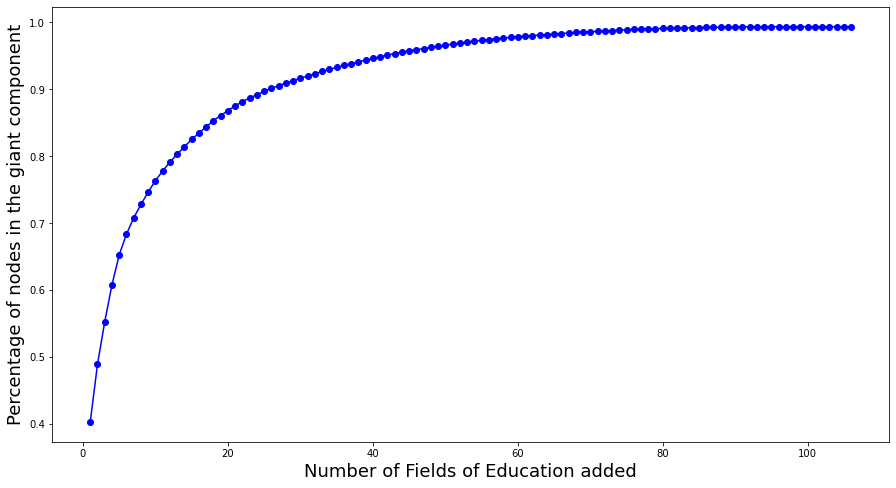

In [13]:
fig = plt.figure(figsize=(15,8))
plt.plot([i+1 for i in range(len(giant_perc_add))], giant_perc_add, 'bo-')
plt.xlabel('Number of Fields of Education added', size=18)
plt.ylabel('Percentage of nodes in the giant component', size=18)
plt.show()

In [14]:
adding_fields_df = pd.DataFrame({'percentage' : giant_perc_add}, index=added_fields).sort_values('percentage')
print('Adding the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:')
display(adding_fields_df.head(10))

Adding the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:


,percentage
business and administration,0.403032
engineering and engineering trades,0.489270
arts,0.552865
languages,0.608191
music and performing arts,0.652884
economics,0.683796
information and communication technologies (icts),0.708210
political sciences and civics,0.728096
nursing and midwifery,0.746801
management and administration,0.763733


In [15]:
removed_fields = []
remaining_fields = list(mobility_df['Field of Education'].unique())
giant_perc_rem =[]
while len(remaining_fields):
    d = {}
    for field in remaining_fields:
        temp_df = mobility_df.loc[~mobility_df['Field of Education'].isin(removed_fields+[field])]
        temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        d[field] = ns.fraction_in_giant(temp_adj)
    new_field = min(d, key=d.get)
    removed_fields.append(new_field)
    remaining_fields.remove(new_field)
    giant_perc_rem.append(d[new_field])

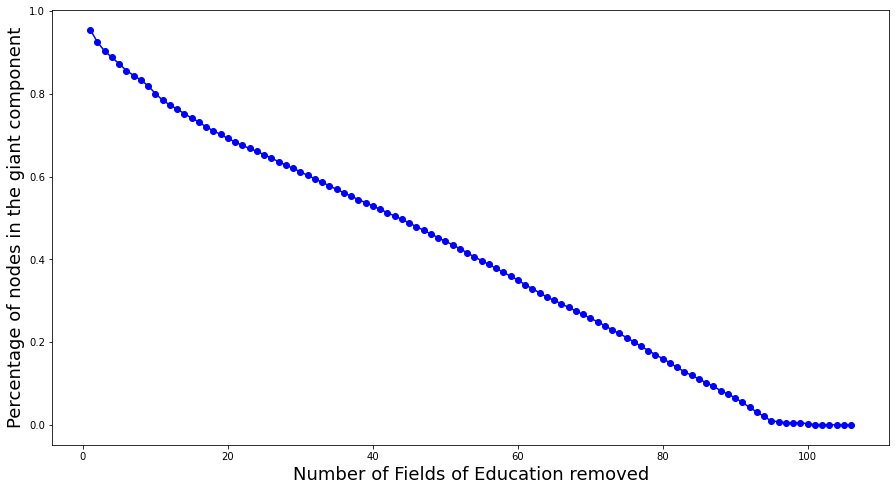

In [16]:
fig = plt.figure(figsize=(15,8))
plt.plot([i+1 for i in range(len(giant_perc_rem))], giant_perc_rem, 'bo-')
plt.xlabel('Number of Fields of Education removed', size=18)
plt.ylabel('Percentage of nodes in the giant component', size=18)
plt.show()

In [17]:
removing_fields_df = pd.DataFrame({'percentage' : giant_perc_rem}, index=removed_fields).sort_values('percentage', ascending=False)
print('Removing the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:')
display(removing_fields_df.head(10))

Removing the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:


,percentage
music and performing arts,0.954912
business and administration,0.924591
engineering and engineering trades,0.902934
economics,0.887970
management and administration,0.872219
information and communication technologies (icts),0.856271
languages,0.844064
arts,0.833235
fine arts,0.819059
"fashion, interior and industrial design",0.800551
